**SEQUENCE TO SEQUENCE WITHOUT ATTENTION**

**Synthetic data generation**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate dummy data
def generate_data(num_samples, seq_len, vocab_size):
    data = []
    for _ in range(num_samples):
        src = [random.randint(1, vocab_size-1) for _ in range(seq_len)]
        tgt = src[::-1]  # Reverse the source sequence for the target
        data.append((src, tgt))
    return data

vocab_size = 20
seq_len = 10
num_samples = 1000
data = generate_data(num_samples, seq_len, vocab_size)

# Define dummy vocab (for demonstration purposes)
vocab = {str(i): i for i in range(vocab_size)}

**Data Loader**

In [2]:
from torch.utils.data import Dataset, DataLoader

class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

dataset = Seq2SeqDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


**Network Architecture**

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))
        return predictions, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)

        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[:, t] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess

        return outputs

# Initialize the model
input_size = vocab_size
output_size = vocab_size
embed_size = 256
hidden_size = 512
num_layers = 2

# attention = Attention(hidden_size)
encoder = Encoder(input_size, embed_size, hidden_size, num_layers).to(device)
decoder = Decoder(output_size, embed_size, hidden_size, num_layers).to(device)
model = Seq2Seq(encoder, decoder).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Model training and getting the loss**

In [4]:
train_loss_list1 = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss/len(dataloader)
    train_loss_list1.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 2.1353
Epoch [2/10], Loss: 1.8162
Epoch [3/10], Loss: 1.6654
Epoch [4/10], Loss: 1.3180
Epoch [5/10], Loss: 1.0990
Epoch [6/10], Loss: 0.7797
Epoch [7/10], Loss: 0.7473
Epoch [8/10], Loss: 0.6846
Epoch [9/10], Loss: 0.5377
Epoch [10/10], Loss: 0.5775


**Model evaluation and getting the evaluation metrics**

In [5]:
from sklearn.metrics import accuracy_score

all_preds = []
all_trues = []

model.eval()
with torch.no_grad():
    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        output = model(src, tgt, teacher_forcing_ratio=0)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        pred = output.argmax(1).view(-1, seq_len-1)
        print(f'Source: {src[0].cpu().numpy()}')
        print(f'Target: {tgt.view(-1, seq_len-1)[0].cpu().numpy()}')
        print(f'Predicted: {pred[0].cpu().numpy()}')

        preds = output.argmax(1).cpu().numpy()
        trues = tgt.cpu().numpy()

        all_preds.extend(preds)
        all_trues.extend(trues)
        break

    accuracy = accuracy_score(all_trues, all_preds)
    print(f'\nAccuracy: {accuracy:.2f}%')

    metrics1 = {'Attention':'Without attention','Accuracy':round(accuracy,2)}

Source: [ 5 14  8  4  3  1  2  7 18 16]
Target: [18  7  2  1  3  4  8 14  5]
Predicted: [18  7  2  1  3  4  8 14  5]

Accuracy: 0.84%


**SEQUENCE TO SEQUENCE WITH ATTENTION**

**Data Loader**

In [ ]:
from torch.utils.data import Dataset, DataLoader

class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

dataset = Seq2SeqDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


**Network Architecture with attention**

In [6]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        attn_energies = self.score(H, encoder_outputs)
        return torch.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers, attention):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.attention = attention
        self.embedding = nn.Embedding(output_size, embed_size)
        self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs)
        rnn_input = torch.cat((embedding, context), dim=2)
        outputs, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))
        return predictions, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(source)

        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess

        return outputs

# Initialize the model
input_size = vocab_size
output_size = vocab_size
embed_size = 256
hidden_size = 512
num_layers = 2

attention = Attention(hidden_size)
encoder = Encoder(input_size, embed_size, hidden_size, num_layers).to(device)
decoder = Decoder(output_size, embed_size, hidden_size, num_layers, attention).to(device)
model = Seq2Seq(encoder, decoder).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Model training and getting the loss**

In [7]:
train_loss_list2 = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss/len(dataloader)
    train_loss_list2.append(train_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 2.1300
Epoch [2/10], Loss: 1.7635
Epoch [3/10], Loss: 1.3383
Epoch [4/10], Loss: 1.0693
Epoch [5/10], Loss: 0.8037
Epoch [6/10], Loss: 0.2742
Epoch [7/10], Loss: 0.0969
Epoch [8/10], Loss: 0.2533
Epoch [9/10], Loss: 0.0869
Epoch [10/10], Loss: 0.0868


**Model evaluation and getting the evaluation metrics**

In [8]:
from sklearn.metrics import accuracy_score

all_preds = []
all_trues = []

model.eval()
with torch.no_grad():
    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        output = model(src, tgt, teacher_forcing_ratio=0)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        pred = output.argmax(1).view(-1, seq_len-1)
        print(f'Source: {src[0].cpu().numpy()}')
        print(f'Target: {tgt.view(-1, seq_len-1)[0].cpu().numpy()}')
        print(f'Predicted: {pred[0].cpu().numpy()}')

        preds = output.argmax(1).cpu().numpy()
        trues = tgt.cpu().numpy()

        all_preds.extend(preds)
        all_trues.extend(trues)
        break

    accuracy = accuracy_score(all_trues, all_preds)
    print(f'\nAccuracy: {accuracy:.2f}%')

    metrics2 =  {'Attention':'With attention','Accuracy':round(accuracy,2)}


Source: [11  8 18 16 12  8  2 19 10  4]
Target: [10 19  2  8 12 16 18  8 11]
Predicted: [10 19  2  8 12 16 18  8 11]

Accuracy: 0.99%


**Plotting loss curve**

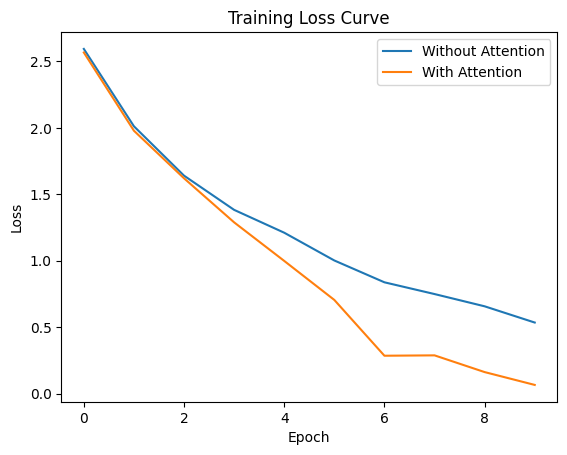

In [9]:
# Plot the loss curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss_list1, label='Without Attention')
plt.plot(train_loss_list2, label='With Attention')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()



**Comparing evaluation metrics**

In [10]:
import pandas as pd
df1 = pd.DataFrame(metrics1, index=[0])
df2 = pd.DataFrame(metrics2, index=[0])
df = pd.concat([df1,df2],axis=0,ignore_index=True)
df.round({'Accuracy':2})
print(df)

           Attention  Accuracy
0  Without attention      0.84
1     With attention      0.99
